In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Task 1: Importing required libraries and Reading in all the historical data and combine it into a single data frame. Also, reading the additional supplementary data in a single dataframe.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

folder_path = '/content/drive/My Drive/Colab Notebooks/CQuant.io'

subfolder_dataframes = {}

# Loop through all subfolders within the main folder
for subfolder in os.listdir(folder_path):
  subfolder_path = os.path.join(folder_path, subfolder)

  # Check if it's a directory (not a file)
  if os.path.isdir(subfolder_path):
    all_files = os.listdir(subfolder_path)
    dataframes = []

    # Loop through each file in the subfolder
    for file in all_files:
      if file.endswith(".csv"):
        filepath = os.path.join(subfolder_path, file)
        df = pd.read_csv(filepath)
        dataframes.append(df)

    # Check if there are multiple files and concatenate them
    if len(dataframes) > 1:
      combined_df = pd.concat(dataframes, ignore_index=True)  # Combine DataFrames
    else:
      combined_df = dataframes[0]  # Use the single DataFrame

    # Store the combined DataFrame for this subfolder
    subfolder_dataframes[subfolder] = combined_df
powerprices=subfolder_dataframes['historicalPriceData']
powerprices.head()
spot=subfolder_dataframes['supplementalMaterials']
spot.head()

,Variable,Date,X1,X2,X3,X4,X5,X6,X7,X8,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
0,ISONE_Node2,2014-01-01,144.64,126.11,115.30,104.40,116.97,152.51,194.90,157.04,...,183.61,187.55,214.54,294.29,260.41,205.53,199.11,181.16,159.12,132.36
1,ISONE_Node2,2014-01-02,159.81,157.33,156.10,156.51,154.21,155.74,166.00,176.36,...,179.60,171.95,193.93,266.38,216.31,193.91,189.86,170.70,158.91,158.17
2,ISONE_Node2,2014-01-03,185.55,176.99,170.51,167.47,177.56,202.67,240.82,242.45,...,220.09,220.47,240.83,297.70,265.19,239.01,236.91,233.55,222.74,214.80
3,ISONE_Node2,2014-01-04,196.16,183.81,170.08,157.41,150.03,156.68,177.50,198.35,...,129.59,131.06,192.15,253.08,207.50,173.57,161.71,143.87,119.65,124.08
4,ISONE_Node2,2014-01-05,115.10,89.88,82.25,79.51,83.11,91.03,103.26,105.24,...,103.85,86.64,131.32,184.71,140.59,129.16,117.44,97.75,80.98,71.54


Task 2 and Task 3: Thks section computes the average price for each settlement point and year-month in the historical dataset and also writes the computed monthly average prices to file as a CSV named
AveragePriceByMonth.csv.

In [20]:
def compute_monthly_average_price(df):
  """
  This function computes the average price for each settlement point and year-month in the DataFrame.

  Args:
      df (pandas.DataFrame): The DataFrame containing the data.

  Returns:
      pandas.Series: A Series containing the average price for each settlement point and year-month.
  """

    # Extract year and month from the 'Date' column
  df['Year'] = pd.to_datetime(df['Date']).dt.year
  df['Month'] = pd.to_datetime(df['Date']).dt.month

 # Group by settlement point, year, and month
  grouped_df = df.groupby(['SettlementPoint', 'Year', 'Month'])

  # Calculate average
  stats_df = grouped_df['Price'].agg('mean').to_frame('AveragePrice')



  stats_df = stats_df.reset_index()
# Reset the index to include settlement point, year, and month as columns
  return stats_df

# Print the result
stats_df = compute_monthly_average_price(powerprices.copy())
stats_df.info()
from google.colab import files
stats_df.to_csv('AveragePriceByMonth.csv', index=False)
#files.download('AveragePriceByMonth.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SettlementPoint  681 non-null    object 
 1   Year             681 non-null    int32  
 2   Month            681 non-null    int32  
 3   AveragePrice     681 non-null    float64
dtypes: float64(1), int32(2), object(1)
memory usage: 16.1+ KB


Task 4 and 5: This section computes the hourly price volatility for each year and each settlement hub in the
historical power price data and also writes the computed hourly volatilities for each settlement hub and each historical
year to file as a CSV.


In [22]:
#Task 4 and 5
def calculate_volatility(prices):
    #prices.shift(1): This shifts the prices series down by one period
    #np.log(prices / prices.shift(1)): This computes the log return for each hour.
    log_returns = np.log(prices / prices.shift(1)).dropna()
    #dropna(): This removes any NaN values resulting from the shift operation
    volatility = log_returns.std(ddof=1)
    return volatility
def compute_hourly_volatility(df):
  """
  This function computes the hourly price volatility for each year and settlement hub in the DataFrame.

  Args:
      df (pandas.DataFrame): The DataFrame containing the data.

  Returns:
      pandas.DataFrame: A DataFrame containing the hourly volatility for each settlement hub and year.
  """
  # Filter for hubs (SettlementPoint starting with "HB_") and positive prices
  df_filtered = df[df['SettlementPoint'].str.startswith("HB_")]
  df_filtered = df_filtered[df_filtered['Price'] > 0]# Filter out zero and negative prices

  # Convert 'Date' to datetime and extract year
  df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
  df_filtered['Year'] = df_filtered['Date'].dt.year

  # Group by SettlementPoint and year, calculate log returns, and standard deviation
  hourly_vols = df_filtered.groupby(['SettlementPoint', 'Year'])['Price'].apply(
      calculate_volatility
  ).reset_index()

# Rename the 'Price' column to 'HourlyVolatility'
  hourly_vols.columns = ['SettlementPoint', 'Year', 'HourlyVolatility']

  return hourly_vols
# Writing to CSV file
hourly_vols = compute_hourly_volatility(powerprices.copy())
hourly_vols.to_csv('HourlyVolatilityByYear.csv', index=False)
#files.download('HourlyVolatilityByYear.csv')
hourly_vols.head()

,SettlementPoint,Year,HourlyVolatility
0,HB_BUSAVG,2016,0.185773
1,HB_BUSAVG,2017,0.154092
2,HB_BUSAVG,2018,0.200254
3,HB_BUSAVG,2019,0.249378
4,HB_HOUSTON,2016,0.191099


Task 6: This section determines which settlement hub showed the highest overall hourly volatility for
each historical year.

In [24]:
def find_max_volatility_per_year(hourly_vols):
  """
  This function extracts the rows with the highest hourly volatility for each year.

  Args:
      hourly_vols (pandas.DataFrame): The DataFrame containing hourly volatility data.

  Returns:
      pandas.DataFrame: A DataFrame containing the rows with the highest volatility for each year.
  """
# Group by year and get the index of the maximum volatility for each year
  max_vol_indices = hourly_vols.groupby('Year')['HourlyVolatility'].idxmax()

  # Select the rows with the maximum volatility using the indices
  max_vols = hourly_vols.loc[max_vol_indices]

  return max_vols
max_vols = find_max_volatility_per_year(hourly_vols.copy())
max_vols.to_csv('MaxVolatilityByYear.csv', index=False)
files.download('MaxVolatilityByYear.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Task 7

In [74]:
def split_data_by_settlement(powerprices):
  """Splits power prices dataframe by settlement point and returns a dictionary of DataFrames.

  Args:
    powerprices: A pandas DataFrame containing 'Date', 'SettlementPoint', and 'Price' columns.

  Returns:
    A dictionary where keys are settlement points and values are corresponding DataFrames
    with 'Variable', 'Date', 'Price', and 'Hour' columns.
  """
  settlement_data = {}
  for settlement_point in powerprices['SettlementPoint'].unique():
    df = (  # Assign the result to df here
        powerprices[powerprices['SettlementPoint'] == settlement_point]
        .rename(columns={'SettlementPoint': 'Variable'})
        [['Variable', 'Date', 'Price']]
        .assign(Hour=lambda x: pd.to_datetime(x['Date']).dt.hour)  # Use pd.to_datetime directly
        .assign(**{f'X{i+1}': np.nan for i in range(24)})

        .reset_index(drop=True)

    )
    # Fill X columns with corresponding hourly prices
    for index, row in df.iterrows():  # Now iterate over the correct df
      hour = row['Hour']
      df.loc[index, f'X{hour+1}'] = row['Price']  # Fill X column based on hour
    settlement_data[settlement_point] = df
  return settlement_data

def drop_price_hour(settlement_dfs):
    """
    Removes the 'Price' and 'Hour' columns from each DataFrame in the settlement_dfs dictionary.

    Args:
        settlement_dfs: A dictionary of DataFrames, where keys are settlement points.

    Returns:
        The modified settlement_dfs dictionary with 'Price' and 'Hour' columns removed.
    """
    for settlement_point, df in settlement_dfs.items():
        settlement_dfs[settlement_point] = df.drop(columns=['Price', 'Hour'])
    return settlement_dfs
def format_dates(settlement_dfs):
    """
    Formats the 'Date' column in each DataFrame to YYYY-MM-DD format.

    Args:
        settlement_dfs: A dictionary of DataFrames, where keys are settlement points
                        and values are DataFrames with a 'Date' column.

    Returns:
        The modified settlement_dfs dictionary with formatted dates.
    """
    for settlement_point, df in settlement_dfs.items():
        df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
        settlement_dfs[settlement_point] = df
    return settlement_dfs

def aggregate_hourly_prices(settlement_dfs):
    """
    Aggregates hourly prices for each unique date in the settlement DataFrames.

    Args:
        settlement_dfs: A dictionary of DataFrames, where keys are settlement points
                        and values are DataFrames with 'Variable', 'Date', and X1 to X24 columns.

    Returns:
        A dictionary of aggregated DataFrames, with one row per unique date and
        summed hourly prices in columns X1 to X24.
    """
    aggregated_dfs = {}
    for settlement_point, df in settlement_dfs.items():
        # Group by 'Date' and sum the hourly prices
        aggregated_df = df.groupby(['Date', 'Variable']).sum(numeric_only=True).reset_index()
        aggregated_dfs[settlement_point] = aggregated_df
    return aggregated_dfs

# Assuming 'powerprices' is your DataFrame containing the power prices data
settlement_dfs = split_data_by_settlement(powerprices)
settlement_dfs = drop_price_hour(settlement_dfs)
settlement_dfs = format_dates(settlement_dfs)
settlement_dfs = aggregate_hourly_prices(settlement_dfs)

# Access the DataFrame for 'HB_BUSAVG'
hb_busavg_data = settlement_dfs.get('HB_BUSAVG')

print(hb_busavg_data)

            Date   Variable     X1     X2     X3     X4     X5     X6     X7  \
0     2016-01-01  HB_BUSAVG  18.42  16.15  15.61  15.62  15.94  16.69  18.96   
1     2016-01-02  HB_BUSAVG  18.99  17.94  17.16  17.00  17.90  17.65  20.11   
2     2016-01-03  HB_BUSAVG  17.44  16.46  16.18  16.35  17.01  17.70  19.28   
3     2016-01-04  HB_BUSAVG  17.01  17.07  17.47  18.00  19.34  21.79  53.72   
4     2016-01-05  HB_BUSAVG  15.89  15.88  15.99  16.50  18.00  21.19  48.84   
...          ...        ...    ...    ...    ...    ...    ...    ...    ...   
1456  2019-12-27  HB_BUSAVG  13.98  12.93  12.95  12.55  13.05  13.58  15.63   
1457  2019-12-28  HB_BUSAVG   4.52   3.81   3.74   5.56   9.93  12.82  13.64   
1458  2019-12-29  HB_BUSAVG   6.84   5.24   4.95   6.09   9.52  11.71  13.24   
1459  2019-12-30  HB_BUSAVG  13.58  13.21  14.11  14.71  15.61  17.65  35.20   
1460  2019-12-31  HB_BUSAVG  15.58  15.80  15.93  16.39  16.33  19.11  40.60   

         X8  ...    X15    X16    X17  

In [87]:
one= settlement_dfs.get('HB_BUSAVG')
filename='Spot_HB_BUSAVG.csv'
one.to_csv(filename, index=False)
files.download(filename)
o2= settlement_dfs.get('HB_HOUSTON')
filename='Spot_HB_HOUSTON.csv'
o2.to_csv(filename, index=False)
files.download(filename)
o3= settlement_dfs.get('HB_HUBAVG')
filename='Spot_HHB_HUBAVG.csv'
o3.to_csv(filename, index=False)
files.download(filename)

o4= settlement_dfs.get('HB_NORTH')
filename='Spot_HB_NORTH.csv'
o4.to_csv(filename, index=False)
files.download(filename)

o5= settlement_dfs.get('HB_SOUTH')
filename='Spot_HB_SOUTH.csv'
o5.to_csv(filename, index=False)
files.download(filename)

o6= settlement_dfs.get('HB_WEST')
filename='Spot_HB_WEST.csv'
o6.to_csv(filename, index=False)
files.download(filename)

o7= settlement_dfs.get('LZ_AEN')
filename='Spot_LZ_AEN.csv'
o7.to_csv(filename, index=False)
files.download(filename)

o8= settlement_dfs.get('LZ_CPS')
filename='Spot_LZ_CPS.csv'
o8.to_csv(filename, index=False)
files.download(filename)

o9= settlement_dfs.get('LZ_HOUSTON')
filename='Spot_LZ_HOUSTON.csv'
o9.to_csv(filename, index=False)
files.download(filename)

#o10= settlement_dfs.get('HB_LZ_LCRA')
#filename='Spot_LZ_LCRA.csv'
#o10.to_csv(filename, index=False)
#files.download(filename)

o11= settlement_dfs.get('LZ_NORTH')
filename='Spot_LZ_NORTH.csv'
o11.to_csv(filename, index=False)
files.download(filename)

o12= settlement_dfs.get('HB_HOUSTON')
filename='Spot_HB_HOUSTON.csv'
o12.to_csv(filename, index=False)
files.download(filename)

#o13= settlement_dfs.get('LZ_RAYBNN')
#filename='Spot_LZ_RAYBN.csv'
#o13.to_csv(filename, index=False)
#files.download(filename)

o14= settlement_dfs.get('LZ_SOUTH')
filename='Spot_LZ_SOUTH.csv'
o14.to_csv(filename, index=False)
files.download(filename)

o15= settlement_dfs.get('LZ_WEST')
filename='Spot_LZ_WEST.csv'
o15.to_csv(filename, index=False)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
o10= settlement_dfs.get('LZ_LCRA')
filename='Spot_LZ_LCRA.csv'
o10.to_csv(filename, index=False)
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [90]:
o13= settlement_dfs.get('LZ_RAYBN')
filename='Spot_LZ_RAYBN.csv'
o13.to_csv(filename, index=False)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

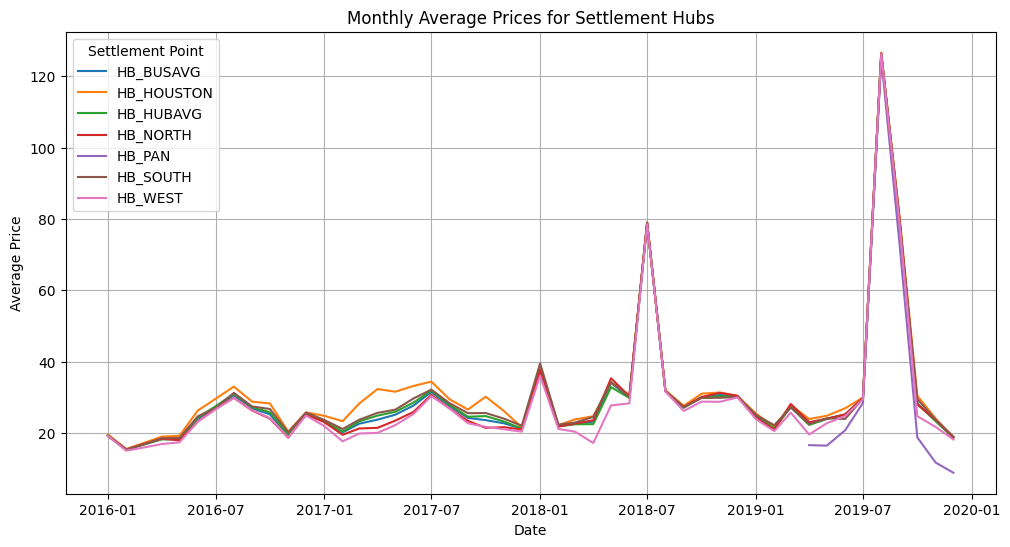

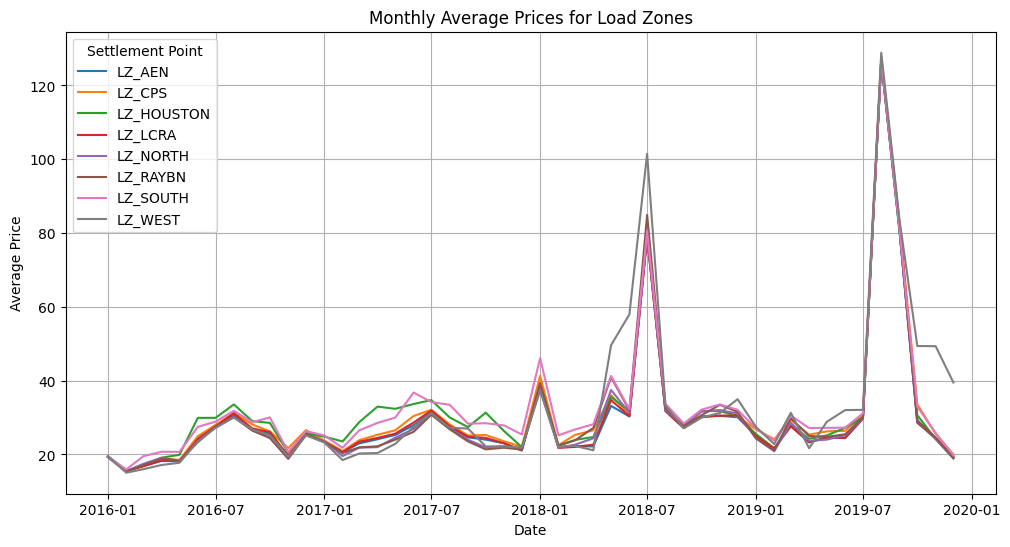

In [91]:
#bonus
# Load the CSV file
file_path = '/content/drive/My Drive/Colab Notebooks/CQuant.io/AveragePriceByMonth (1).csv'
stats_df = pd.read_csv(file_path)

# Create a date column for chronological ordering
stats_df['Date'] = pd.to_datetime(stats_df[['Year', 'Month']].assign(DAY=1))

# Filter data for hubs and load zones
hubs_df = stats_df[stats_df['SettlementPoint'].str.startswith('HB_')]
load_zones_df = stats_df[stats_df['SettlementPoint'].str.startswith('LZ_')]

# Plot the data for hubs
plt.figure(figsize=(12, 6))
for settlement_point in hubs_df['SettlementPoint'].unique():
    subset = hubs_df[hubs_df['SettlementPoint'] == settlement_point]
    plt.plot(subset['Date'], subset['AveragePrice'], label=settlement_point)
plt.title('Monthly Average Prices for Settlement Hubs')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(title='Settlement Point')
plt.grid(True)
plt.savefig('SettlementHubAveragePriceByMonth.png')
plt.show()

# Plot the data for load zones
plt.figure(figsize=(12, 6))
for settlement_point in load_zones_df['SettlementPoint'].unique():
    subset = load_zones_df[load_zones_df['SettlementPoint'] == settlement_point]
    plt.plot(subset['Date'], subset['AveragePrice'], label=settlement_point)
plt.title('Monthly Average Prices for Load Zones')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(title='Settlement Point')
plt.grid(True)
plt.savefig('LoadZoneAveragePriceByMonth.png')
plt.show()

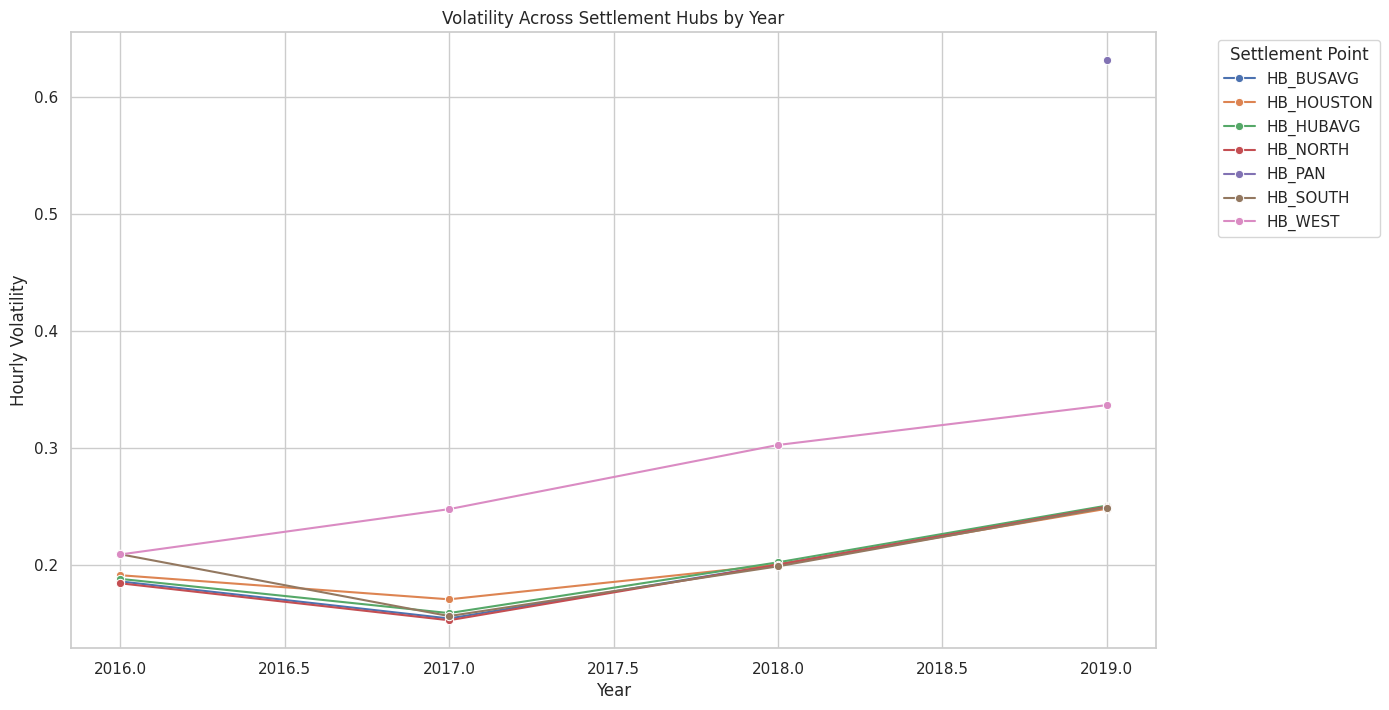

In [92]:
#bonus
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/content/drive/My Drive/Colab Notebooks/CQuant.io/HourlyVolatilityByYear.csv'
volatility_df = pd.read_csv(file_path)

# Filter data to include only settlement hubs (prefix "HB_")
hubs_volatility_df = volatility_df[volatility_df['SettlementPoint'].str.startswith('HB_')]

# Set the plot style
sns.set(style="whitegrid")

# Initialize the plot
plt.figure(figsize=(14, 8))

# Plot the data
sns.lineplot(data=hubs_volatility_df, x='Year', y='HourlyVolatility', hue='SettlementPoint', marker='o')

# Add titles and labels
plt.title('Volatility Across Settlement Hubs by Year')
plt.xlabel('Year')
plt.ylabel('Hourly Volatility')
plt.legend(title='Settlement Point', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Save the plot to a file
plt.savefig('VolatilityAcrossSettlementHubsByYear.png')

# Display the plot
plt.show()